# Performing a classical On/Off analysis

**In this tutorial you will learn to perform a classical On/Off analysis of the data.**

We start by importing the gammalib, ctools, and cscripts Python modules.

In [1]:
import gammalib
import ctools
import cscripts

We will also use matplotlib to display the results.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

And finally we add to our path the directory containing the example plotting scripts provided with the ctools installation.

In [3]:
import sys
import os
sys.path.append(os.environ['CTOOLS']+'/share/examples/python/')

## Classical analysis without background model

### Preparation of the On/Off binned data

The first step for a classical analysis is to bin the events in bins of energy for an On (signal) region, and one or several Off (background regions).

We will use the event selection performed in the previous tutorial.

In [4]:
obsfile = "obs_crab_selected.xml"

phagen = cscripts.csphagen()
phagen['inobs'] = obsfile
phagen['inmodel'] = 'NONE' # assume that the source is pointlike
phagen['ebinalg'] = 'LOG'
phagen['emin'] = 0.66
phagen['emax'] = 30.
phagen['enumbins'] = 20
phagen['coordsys'] = 'CEL'
phagen['ra'] = 83.63
phagen['dec'] = 22.01
phagen['rad'] = 0.2
phagen['bkgmethod'] = 'REFLECTED'
phagen['use_model_bkg'] = False
phagen['maxoffset'] = 2.0
phagen['stack'] = True
phagen['outobs'] = 'obs_crab_onoff.xml'
phagen['outmodel'] = 'onoff_model.xml'

phagen.execute()

Note that we have used the hidden parameter `use_model_bkg` to specify that no background model should be used in the computation of the background normalisation factor, which is simply assumed to be the ratio of the solid angles of On/Off regions.

Let us peek at the resulting set of On/Off observations.

In [5]:
print(phagen.obs()[0])

=== GCTAOnOffObservation ===
 Name ......................: 
 Identifier ................: 
 Instrument ................: HESSOnOff
 Statistic .................: wstat
 Ontime ....................: 6313.8117676 s
 Livetime ..................: 6313.8117676 s
 Deadtime correction .......: 1
=== GPha ===
 Exposure ..................: 6313.8117676 s
 Number of bins ............: 20
 Energy range ..............: 660 GeV - 30 TeV
 Observation energy range ..: 660.693448007596 GeV - 100 TeV
 Total number of counts ....: 576
 Underflow counts ..........: 0
 Overflow counts ...........: 1
 Outflow counts ............: 0
=== GPha ===
 Exposure ..................: 6313.8117676 s
 Number of bins ............: 20
 Energy range ..............: 660 GeV - 30 TeV
 Observation energy range ..: 660.693448007596 GeV - 100 TeV
 Total number of counts ....: 772
 Underflow counts ..........: 0
 Overflow counts ...........: 4
 Outflow counts ............: 0
=== GArf ===
 Number of bins ............: 61
 Energy

Note that the instrument is now `HESSOnOff`, to signify that we are dealing with On/Off observations. Since we have no background model the statistic has been set to `WSTAT`. The script has also created a model for the On region.

In [6]:
print(phagen.obs().models())

=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 6
=== GModelSky ===
 Name ......................: Dummy
 Instruments ...............: all
 Instrument scale factors ..: unity
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.63 deg (fixed,scale=1)
  DEC ......................: 22.01 deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 1e-18 +/- 0 [0,infty[ ph/cm2/s/MeV (free,scale=1e-18,gradient)
  Index ....................: -2 +/- 0 [10,-10]  (free,scale=-2,gradient)
  PivotEnergy ..............: 1000000 MeV (fixed,scale=1000000,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,scale=1,gradient)


Since we do not have specified any input model the script has placed a point source named `Dummy`, at the center of the On region with a power law spectrum. We will rename this source as Crab. At this point you can also modify the spectral model, e.g., to use more appropriate parameter values or a different spectral shape.

In [7]:
phagen.obs().models()['Dummy'].name('Crab')

### Likelihood fit and residuals

We can now fit this model to the data.

In [8]:
like = ctools.ctlike(phagen.obs())

like.run()

Let's look at the results from the optimisation and the fitted model.

In [9]:
print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: 15.746
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 6
 Number of free parameters .: 2
 Number of iterations ......: 11
 Lambda ....................: 0.0001
=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 6
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Instrument scale factors ..: unity
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.63 deg (fixed,scale=1)
  DEC ......................: 22.01 deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 4.61852950191309e-17 +/- 2.97687577951453e-18 [0,infty[ ph/cm2/s/MeV (free,scale=1e-18,gradient)
  Index ........

The fit has properly converged and the results are consistent with those obtained with the unbinned analysis.

We will also check the spectral residuals.

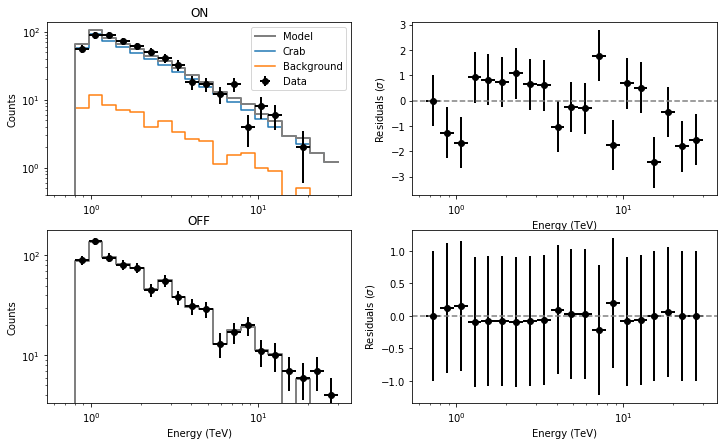

In [10]:
residuals = 'residuals_classical_nobkg.fits'
res = cscripts.csresspec(like.obs())

res['components'] = True
res['algorithm'] = 'SIGNIFICANCE'
res['outfile'] = residuals

res.execute()

from show_residuals import plot_residuals
plot_residuals(residuals,'',0)

## Classical analysis with a background model

### Preparation of the On/Off binned data

If a background model is available this can be used to compute the expected background rates for different observations as a function of energy and normalise the number of background counts between On and Off regions. Here we will use the background model derived using csbkgmodel.

In [11]:
srcmodel = os.environ['CTOOLS']+'/share/models/crab_nobkg.xml'
bkgmodel = 'bkgmodel.xml'
startmodel = 'model_classical_bkg.xml'

merge = cscripts.csmodelmerge()
merge['inmodels'] = srcmodel + ' ' + bkgmodel
merge['outmodel'] = startmodel

merge.execute()

Now we can run csphagen using this model including the background in input. Note that since the background model is defined per observation we will not stack the observations together.

In [12]:
phagen = cscripts.csphagen()
phagen['inobs'] = obsfile
phagen['inmodel'] = startmodel
phagen['ebinalg'] = 'LOG'
phagen['emin'] = 0.66
phagen['emax'] = 30.
phagen['enumbins'] = 20
phagen['coordsys'] = 'CEL'
phagen['ra'] = 83.63
phagen['dec'] = 22.01
phagen['rad'] = 0.2
phagen['bkgmethod'] = 'REFLECTED'
phagen['use_model_bkg'] = True
phagen['maxoffset'] = 2.0
phagen['stack'] = False # treat observations separately in joint likelihood fit

phagen.run()

### Likelihood fit and residuals

We will now fit the model to the data and look at the results.

In [13]:
like = ctools.ctlike(phagen.obs())

like.run()

print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: -2417.569
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 86
 Number of free parameters .: 46
 Number of iterations ......: 27
 Lambda ....................: 0.0001
=== GModels ===
 Number of models ..........: 5
 Number of parameters ......: 86
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Instrument scale factors ..: unity
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.6331 [-360,360] deg (fixed,scale=1)
  DEC ......................: 22.0145 [-90,90] deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 4.44948855977292e-17 +/- 2.98608147595163e-18 [1e-24,1e-14] ph/cm2/s/MeV (free,scal

Results for the spectrum of the Crab nebula are once again consistent with those obtained before. Note how the spatial parameters of the background model, although formally free, have not been optimised (their errors are 0), since we are running a spectral analysis only.

Since we have provided a background model to csphagen the statistic was set by default to `CSTAT`, i.e. the background model was also used in the fit. You may also specify as statistic in ctlike `WSTAT`. In this case the spectral model for the background would be derived from the data during the fit, and the impact of the model used above would extend only to the computation of the background normalisation factor between On and Off regions. Using an a-priori background model on the other hand can be advantageous to avoid intrinsic biases of WSTAT when the counting statistics are limited.

Let's check the residuals for the first of the 4 observations.

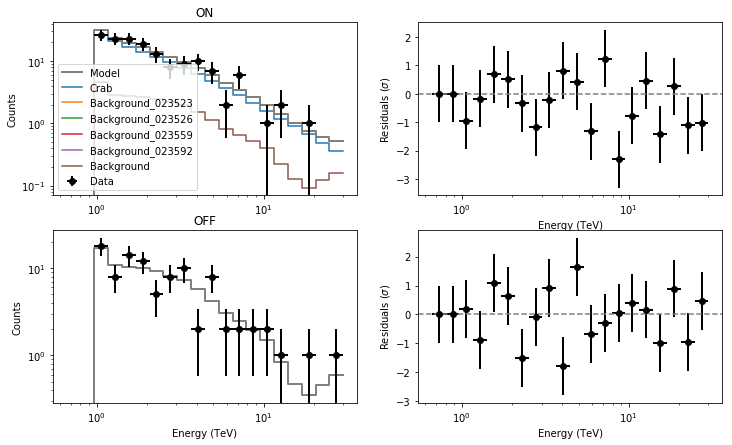

In [14]:
residuals = 'residuals_classical_bkgmod.fits'
res = cscripts.csresspec(like.obs())

res['components'] = True
res['algorithm'] = 'SIGNIFICANCE'
res['outfile'] = residuals

res.execute()

from show_residuals import plot_residuals
plot_residuals(residuals,'',0)

As expected the spectral residuals are not as good as in the first analysis in which the model was derived from the data during the fit itself, but the models still satisfactorily reproduces the data. Of course the total background coincides with the background model of the specific observation considered.